<a href="https://colab.research.google.com/github/ranjith13119/SentimentAnalysis_Attention_BILSTM/blob/main/IMDB_BILSTM_with_Attension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# %cd /content/drive/MyDrive/NLP/Attention
# !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zipy
#https://github.com/bentrevett/pytorch-sentiment-analysis

In [37]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
dataset = pd.read_csv("/content/drive/MyDrive/NLP/Attention/IMDB Dataset.csv")

In [39]:
dataset.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [40]:
dataset.shape

(50000, 2)

In [41]:
df = dataset.copy()

In [42]:
df.sentiment = df.sentiment.map({
    'positive' : 1,
    'negative' : 0
})

In [43]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [44]:
def clean_text(text):
    '''
      This function will return the processed review texts
    '''
    text = re.sub(r'[^\w\s]','',text, re.UNICODE) 
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text] # find the lemma word
    text = [word for word in text if  not word in stop_words] # remove the english stop words
    text = " ".join(text)
    return text

In [45]:
df['preprossed_data'] = df.review.apply(lambda x : clean_text(x))

In [46]:
df.head()

,review,sentiment,preprossed_data
0,One of the other reviewers has mentioned that ...,1,one reviewer ha mention watch 1 oz episode you...
1,A wonderful little production. <br /><br />The...,1,wonderful little production br br film techniq...
2,I thought this was a wonderful way to spend ti...,1,think wa wonderful way spend time hot summer w...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stun f...


In [47]:
df['preprossed_data'].apply(lambda x : len(x.split(" "))).mean()

127.98498

In [48]:
MAX_FEATURES = 6000  # vocab size
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['preprossed_data'])
list_tokenized_train = tokenizer.texts_to_sequences(df['preprossed_data']) # convert the text into sequence of token vectors

RNN_CELL_SIZE = 32
  
MAX_LEN = 129  # Since our mean length is 127.98498
X = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y = df['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3 ,random_state = 42)

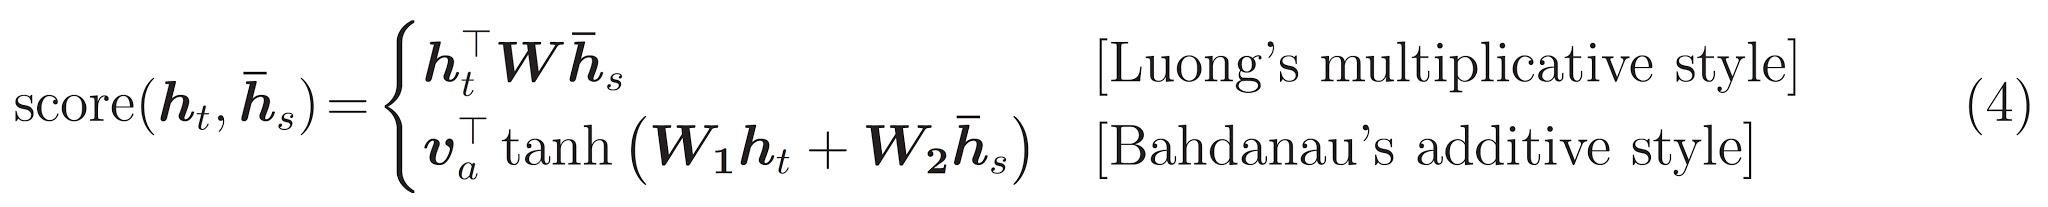

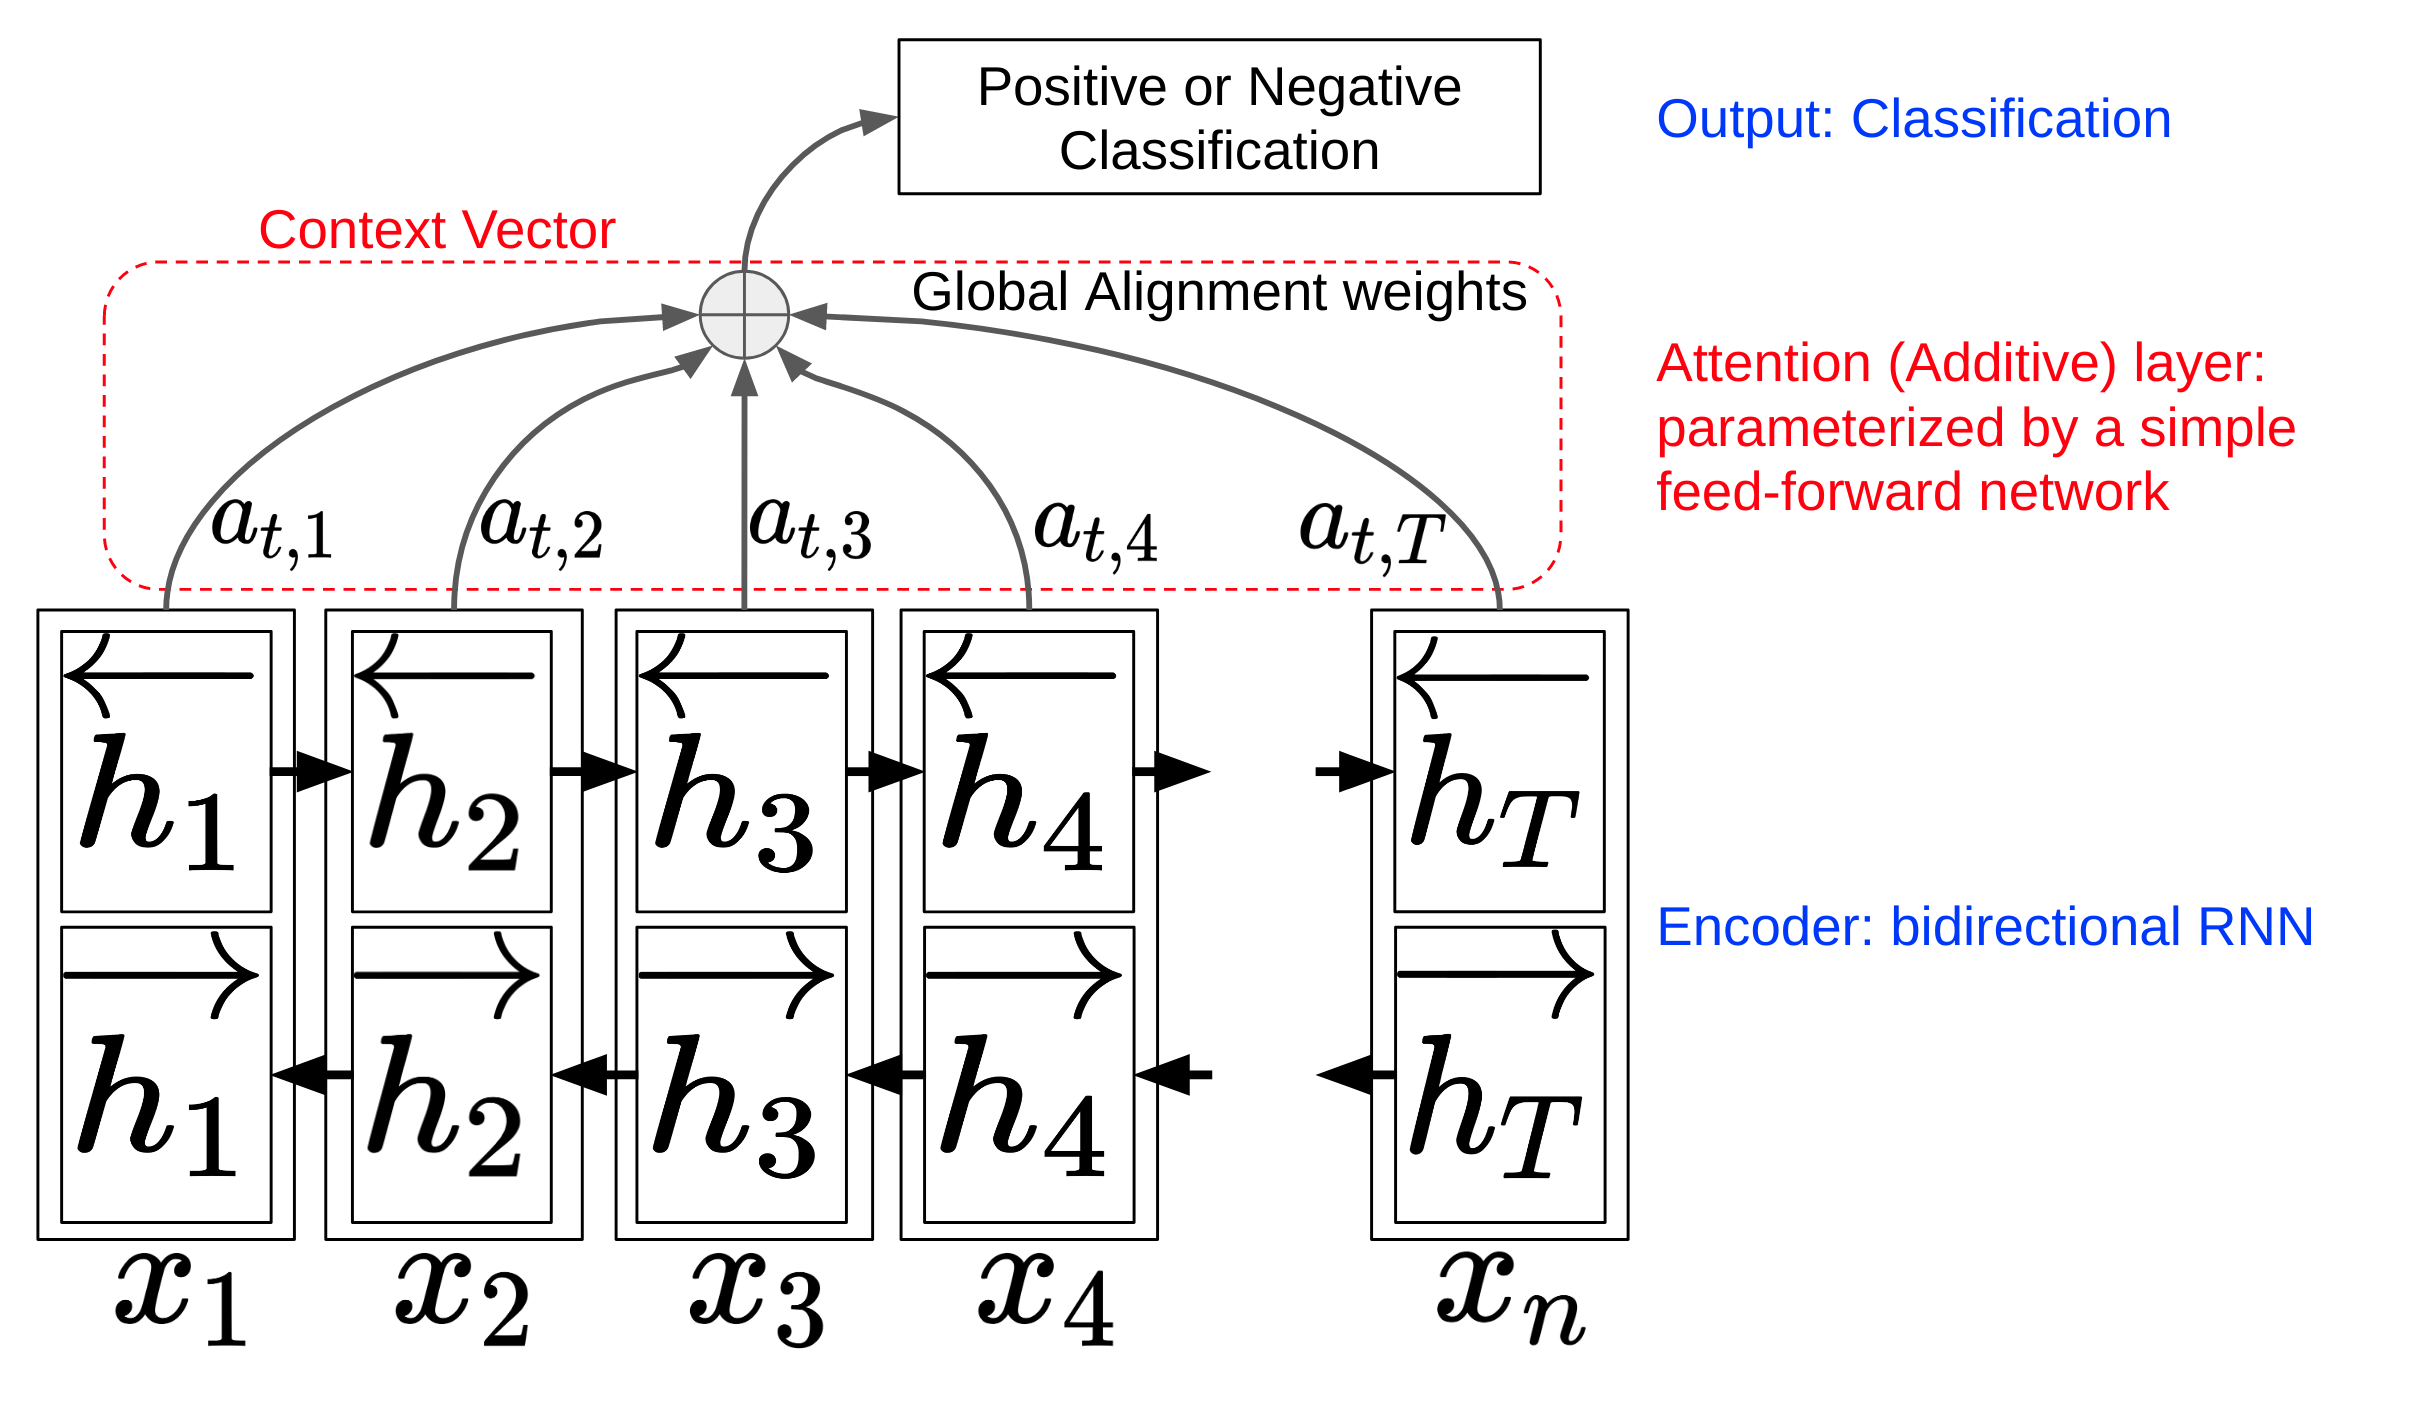

In [50]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #@eq.4 w1
        self.W2 = tf.keras.layers.Dense(units) #@eq.4 w2
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):

        # we are doing this to perform addition to calculate the score
        # expand_dims will not add or reduce elements in a tensor, it just changes the shape by adding 1 to dimensions. 
        # For example, a vector with 32 elements could be treated as a 32x1 matrix

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)

        score = tf.nn.tanh( self.W1(features) + self.W2(hidden_with_time_axis)) #@eq.4b
        attention_weights = tf.nn.softmax(self.V(score), axis=1) # to make the feedforward weight to 1
          
        context_vector = attention_weights * features # multiply the wieight with features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # calculate all the weight and send it to output
        return context_vector, attention_weights

In [51]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [52]:
# Input as a LSTM
# rune the bidirectional LSTM with batch size as 32
# LSTM1, i'm only returning the sequence of vectors not the state
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [53]:
state_h = Concatenate()([forward_h, backward_h]) # combining both direction outputs
state_c = Concatenate()([forward_c, backward_c])  # combining both direction hidden cell states

In [54]:
# context_vector  -> tokenized context vector from the attension layer
# attention_weights -> all the attension weights
context_vector, attention_weights = Attention(10)(lstm, state_h) 
dense1 = Dense(units=20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1) # adding dropout layer to avoid overfitting
output = Dense(1, activation="sigmoid")(dropout) # we are using sigmoid activation function as our output is binary classification

In [55]:
model = keras.Model(inputs=sequence_input, outputs=output)

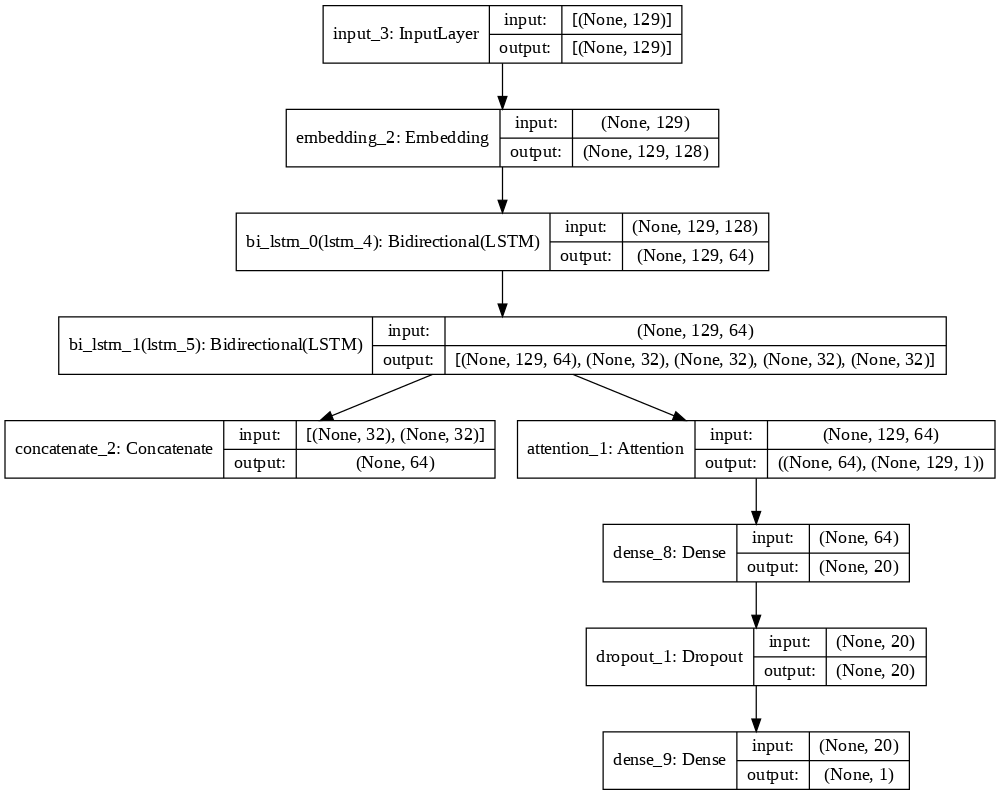

In [56]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [57]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [58]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
267/267 [==============================] - 20s 49ms/step - loss: 0.3731 - tp: 10771.0000 - fp: 2098.0000 - tn: 11279.0000 - fn: 2518.0000 - accuracy: 0.8269 - precision: 0.8370 - recall: 0.8105 - auc: 0.9133 - val_loss: 0.3044 - val_tp: 2841.0000 - val_fp: 354.0000 - val_tn: 2978.0000 - val_fn: 494.0000 - val_accuracy: 0.8728 - val_precision: 0.8892 - val_recall: 0.8519 - val_auc: 0.9473
Epoch 2/5
267/267 [==============================] - 11s 41ms/step - loss: 0.2396 - tp: 12113.0000 - fp: 1304.0000 - tn: 12073.0000 - fn: 1176.0000 - accuracy: 0.9070 - precision: 0.9028 - recall: 0.9115 - auc: 0.9642 - val_loss: 0.2968 - val_tp: 2882.0000 - val_fp: 365.0000 - val_tn: 2967.0000 - val_fn: 453.0000 - val_accuracy: 0.8773 - val_precision: 0.8876 - val_recall: 0.8642 - val_auc: 0.9492
Epoch 3/5
267/267 [==============================] - 11s 42ms/step - loss: 0.1900 - tp: 12373.0000 - fp: 1026.0000 - tn: 12351.0000 - fn: 916.0000 - accuracy: 0.9272 - precision: 0.9234 - recall: 0.

In [ ]:
# Loading the test dataset, and repeating the processing steps
# df_test=pd.read_csv("testData.tsv",header=0, delimiter="\t", quoting=3)
# df_test.head()
# df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
# df_test["sentiment"] = df_test["id"].map(lambda x: 1  if  int(x.strip('"').split("_")[1]) >= 5  else  0)
# y_test = df_test["sentiment"]
# list_sentences_test = df_test["review"]
# list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)
  
## Making predictions on our model

prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      8291
           1       0.86      0.86      0.86      8376

    accuracy                           0.86     16667
   macro avg       0.86      0.86      0.86     16667
weighted avg       0.86      0.86      0.86     16667



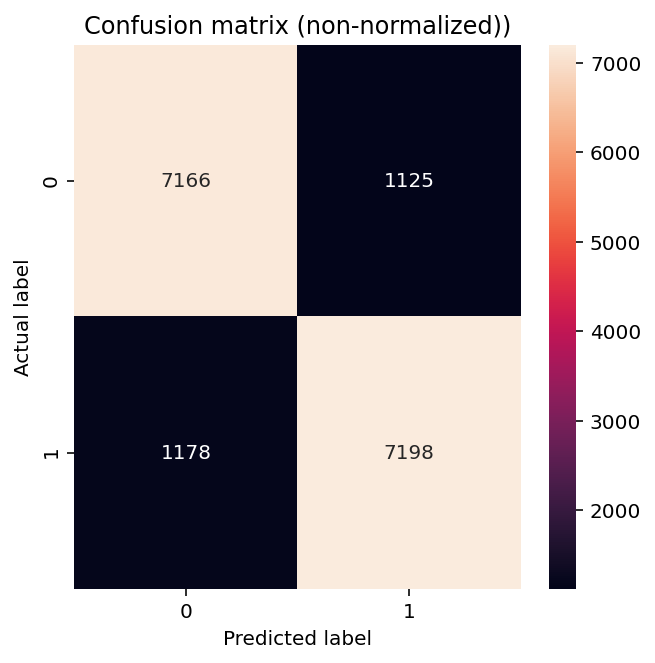

In [63]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

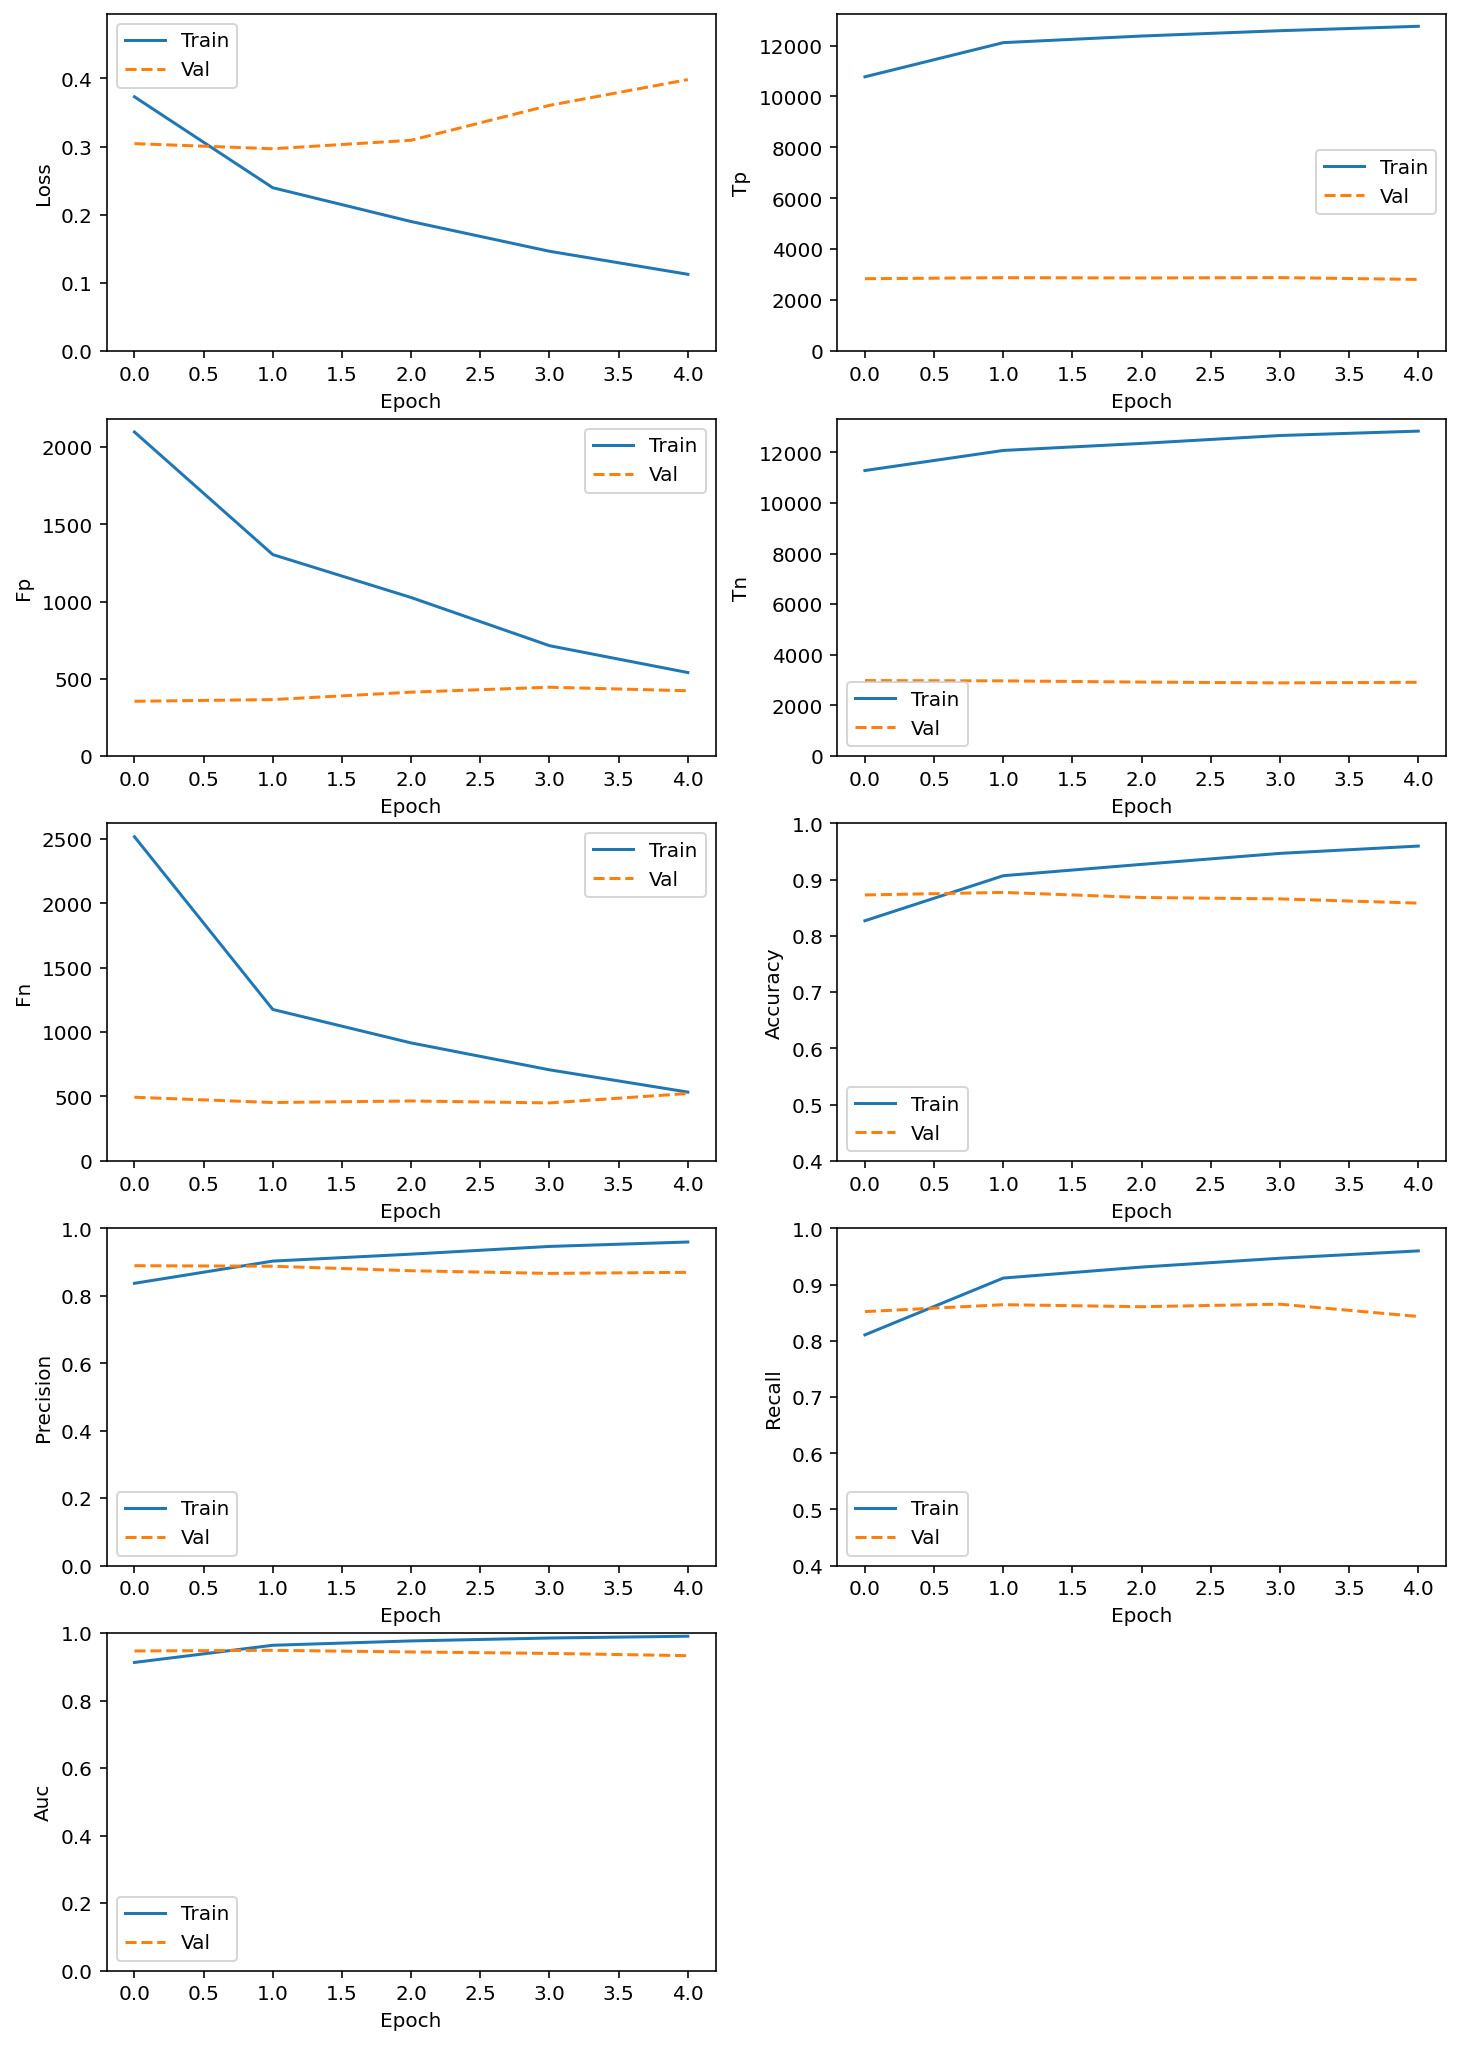

In [64]:
# Cross Validation Classification Accuracy
  
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)
  
def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in  enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])
          
        plt.legend()
  
plot_metrics(history)

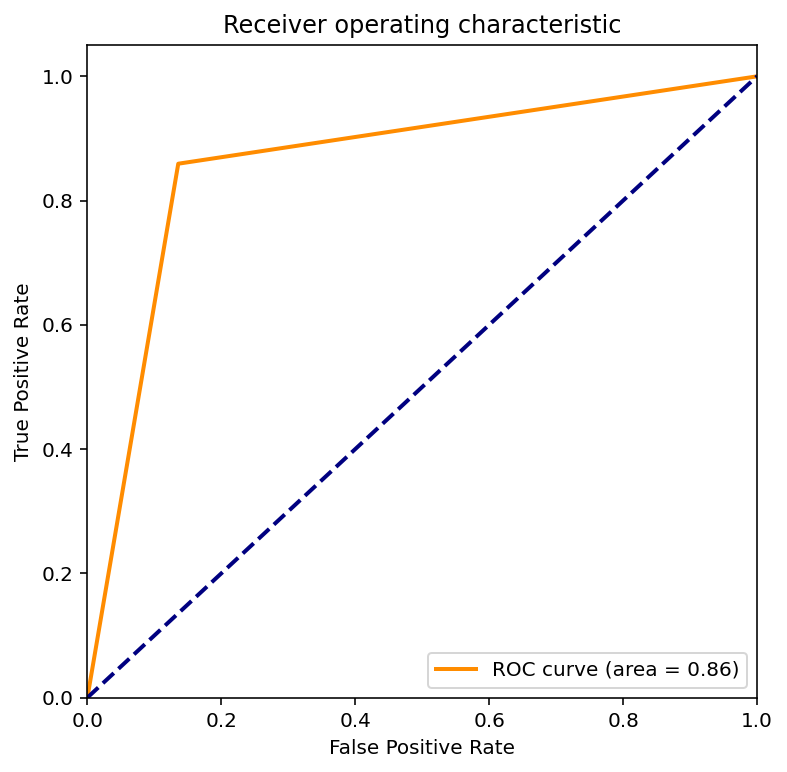

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
  
mpl.rcParams["figure.figsize"] = (6, 6)
  
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score
  
# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1
  
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in  range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()